In [8]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to c:\users\shannon\appdata\local\temp\pip-req-build-m1i5z9we
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit e17ed5cd50a1b43ed60ca4ff7a9a2e329c17c012
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp312-cp312-win_amd64.whl size=874753 sha256=215b4aa713b798bd9de8ccac1ab2950512ca5bf4fa29f48e52d1485961091260
  Stored in directory: C:\Users\shannon\AppData\Local\Temp\pip-ephem-wheel-cache-wz08psfy\wheels\a3\b2\24\3bfb1ad262dd7389a69f1e1aa2afdd7f4f637b3e72dbb9ffa5
Successfully built pytorch3d
  Attempting uninstall: pytorch3d
    Found existing installation: pytorch3d 0.7.8
    Uninstalling pytorch3d-0.7.8:
      Successfully uninstalled pytorch3d-0.7.8


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git 'C:\Users\shannon\AppData\Local\Temp\pip-req-build-m1i5z9we'


In [1]:
import sys
import os
import torch as th
import cv2

# set the right device
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# NOTE: assuming we are in `ca_body/notebooks`
sys.path.insert(0, 'data')
from attrdict import AttrDict

from omegaconf import OmegaConf
from torchvision.utils import make_grid

from visualize.ca_body.utils.module_loader import load_from_config
from visualize.ca_body.utils.lbs import LBSModule
from visualize.ca_body.utils.train import load_checkpoint

device = th.device('cuda:0')

获取模型

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
!curl -O http://audio2photoreal_models.berkeleyvision.org/PXB184_models.tar
!tar -xvf PXB184_models.tar
!del PXB184_models.tar

#REM 下载和解压 RLW104_models.tar
!curl -O http://audio2photoreal_models.berkeleyvision.org/RLW104_models.tar
!tar -xvf RLW104_models.tar
!del RLW104_models.tar

#REM 创建 checkpoints/ca_body/data/ 目录并下载 PXB184.tar.gz
!mkdir checkpoints\ca_body\data
!curl -L -O https://github.com/facebookresearch/ca_body/releases/download/v0.0.1-alpha/PXB184.tar.gz
!tar -xvf PXB184.tar.gz --directory checkpoints\ca_body\data
!del PXB184.tar.gz

#REM 创建 checkpoints/ca_body/data/ 目录并下载 RLW104.tar.gz
!mkdir checkpoints\ca_body\data
!curl -L -O https://github.com/facebookresearch/ca_body/releases/download/v0.0.1-alpha/RLW104.tar.gz
!tar -xvf RLW104.tar.gz --directory checkpoints\ca_body\data
!del RLW104.tar.gz

#REM 下载和解压 asset_models.tar
!curl -O http://audio2photoreal_models.berkeleyvision.org/asset_models.tar
!tar -xvf asset_models.tar
!del asset_models.tar

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
checkpoints/diffusion/c1_face/model000155000.pt
tar: Unexpected EOF in archive
tar: rmtlseek not stopped at a record boundary
tar: Error is not recoverable: exiting now
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: line 1: del: command not found
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C
/bin/bash: warn

In [3]:
# NOTE: make sure to download the data
model_dir = 'checkpoints/ca_body/data/RLW104/'

ckpt_path = f'{model_dir}/body_dec.ckpt'
config_path = f'{model_dir}/config.yml'
assets_path = f'{model_dir}/static_assets.pt'

# config
config = OmegaConf.load(config_path)
# assets
static_assets = AttrDict(th.load(assets_path, weights_only=True))
# sample batch
batch = th.load(f'{model_dir}/sample_batch.pt', weights_only=True)
batch = {
    key: val.to(device) if th.is_tensor(val) else val
    for key, val in batch.items()
}
# batch = to_device(batch, device)

In [4]:
batch.keys()

dict_keys(['image', 'ao', 'seg_fg', 'seg_part', 'lbs_motion', 'geom', 'face_embs', 'camera_ids', 'campos', 'camrot', 'focal', 'princpt', 'K', 'Rt', '_index', 'face_R', 'face_t'])

In [5]:
# building the model
model = load_from_config(
    config.model, 
    assets=static_assets,
).to(device)

# loading model checkpoint
load_checkpoint(
    ckpt_path, 
    modules={'model': model},
    # NOTE: this is accounting for difference in LBS impl
    ignore_names={'model': ['lbs_fn.*']},
)

/home/shannon/.conda/envs/cas/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[2024-11-02 20:26:58][INFO][visualize.ca_body.utils.geom]:impainting index image might take a while for sizes >= 1024
[2024-11-02 20:26:59][INFO][visualize.ca_body.models.mesh_vae_drivable]:ConvDecoder: n_channels = [64, 32, 16, 8, 4]
/mnt/d/Work/virtualCAS3/visualize/ca_body/nn/layers.py:200: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  wn = WeightNorm.apply(
[2024-11-02 20:26:59][WARNING][visualize.ca_body.nn.color_cal]:Requested color-calibration identity camera not present, defaulting to 400883.
[2024-11-02 20:27:10][INFO][visualize.ca_body

In [15]:
# disabling training-only stuff
model.learn_blur_enabled = False
model.pixel_cal_enabled = False
model.cal_enabled = False

# forward
with th.no_grad():
    preds = model(**batch)

Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

[2024-10-15 16:18:57][WARNING][matplotlib.image]:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11249617..1.0051901].


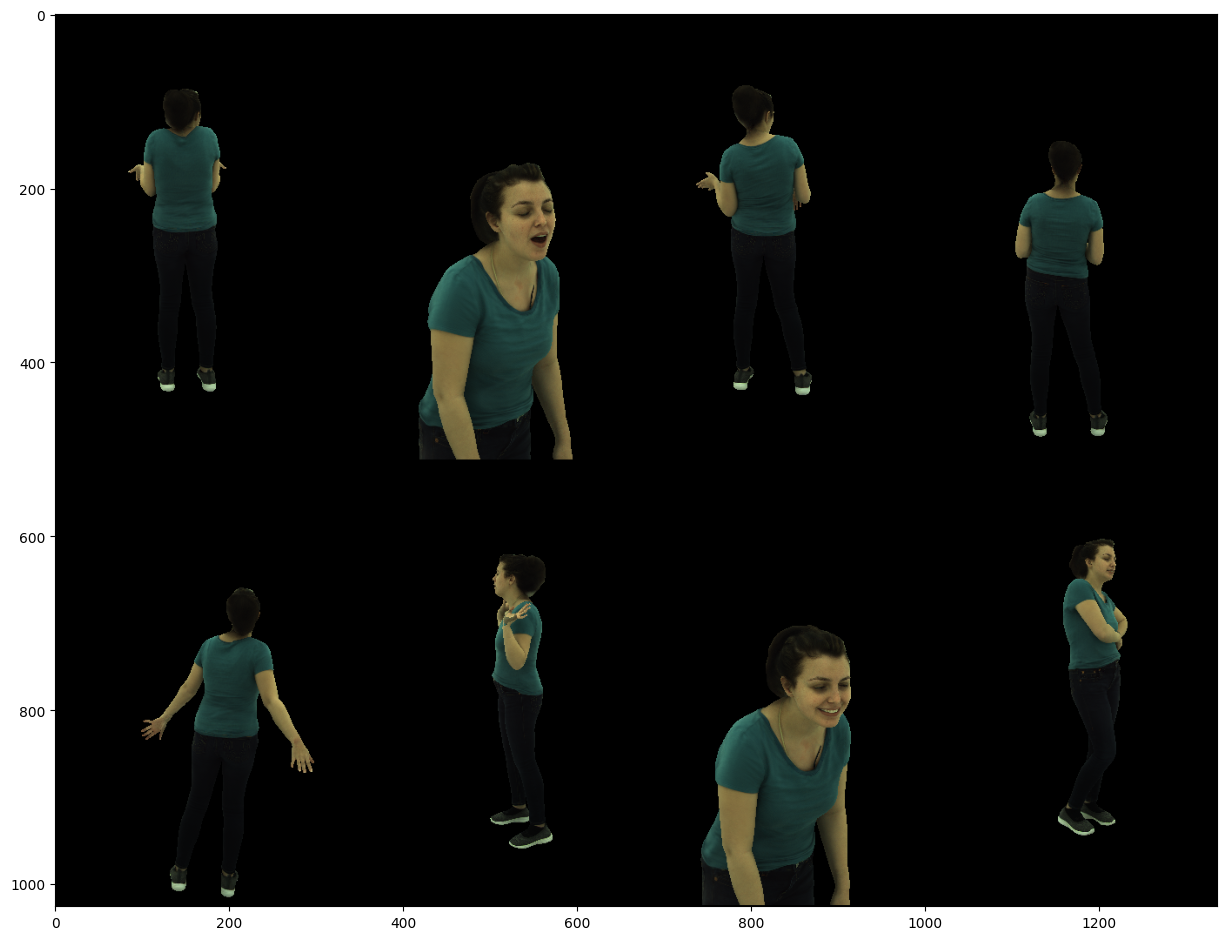

In [16]:
# visualizing
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
rgb_preds_grid = make_grid(preds['rgb'], nrow=4).permute(1, 2, 0).cpu().numpy() / 255.
plt.figure(figsize=(15, 15))
plt.imshow(rgb_preds_grid[::4,::4])